<a href="https://colab.research.google.com/github/kimtomato/torch_example/blob/main/softmax_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn.functional as F

torch.manual_seed(1)

In [ ]:
#low-level 구현

z = torch.FloatTensor([1,2,3])

h = F.softmax(z, dim=0)

In [ ]:
print(h)
print(h.sum())

tensor([0.0900, 0.2447, 0.6652])
tensor(1.)


In [ ]:
#cost function 구현 
z = torch.rand(3,5, requires_grad=True)

h = F.softmax(z,dim=1) #dim=1은 두번재 차원에 대해 softmax를 적용한다는 의미 
print(h)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)


In [ ]:
y = torch.randint(5,(3,)).long()
print(y)

#one-hot encoding

y_one_hot = torch.zeros_like(h)


#y에 1차원 추가후 해당 인자에 위치에 숫자 1을 넣도록, 첫번재 인자는 dim=1에 대해 scatter를 수행하라는 의미 
y_one_hot.scatter_(1,y.unsqueeze(1),1)
print(y_one_hot)

tensor([2, 1, 0])
tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])


In [ ]:
#cost
cost = (y_one_hot * -torch.log(h)).sum(dim=1).mean()
print(cost)

tensor(1.6682, grad_fn=<MeanBackward0>)


In [ ]:
#high level 구현 
F.log_softmax(z,dim=1) #torch.log(F.softmax(z, dim=1)) 과 동일 

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

In [ ]:
F.nll_loss(F.log_softmax(z,dim=1),y)    #-> one hot vector 필요없음 
#(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()
#(y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean() 와 동일

tensor(1.6682, grad_fn=<NllLossBackward0>)

In [ ]:
#F.cross_entropy는 F.log_softmax + F.nll_loss

F.cross_entropy(z,y)

tensor(1.6682, grad_fn=<NllLossBackward0>)

###softmax Regression구현하기 

In [ ]:
## class로 구현 
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

class SoftmaxRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(4,3)

    def forward(self,x):
        return self.linear(x)

model = SoftmaxRegression()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    h = model(x_train)
    cost = F.cross_entropy(h,y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.648873
Epoch  100/1000 Cost: 0.857335
Epoch  200/1000 Cost: 0.778282
Epoch  300/1000 Cost: 0.722384
Epoch  400/1000 Cost: 0.680598
Epoch  500/1000 Cost: 0.648082
Epoch  600/1000 Cost: 0.621954
Epoch  700/1000 Cost: 0.600391
Epoch  800/1000 Cost: 0.582189
Epoch  900/1000 Cost: 0.566527
Epoch 1000/1000 Cost: 0.552827


### Softmax를 이용해 MNIST 데이터 분류하기 

In [1]:
#MNIST : 28x28 pixel 데이터셋 =728의 원소를 가진 벡터 = 784개의 특성을 가진 샘플 
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random 

In [2]:
USE_CUDA = torch.cuda.is_available()

device = torch.device('cuda' if USE_CUDA else "cpu")
print(device)

cuda


In [3]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

#hyperparameter 
training_epochs =15
batch_size =100


In [7]:
#data 불러오기 

#torchvision.datasets.dsets.MNIST
#train을 True로 주면 훈련데이터 리턴, False로 주면 테스트 데이터 리턴 
#transform : 현재 데이터를 파이토치 텐서로 변환 

mnist_train = dsets.MNIST(root='MNIST_data/', train=True, transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', train =False, transform=transforms.ToTensor(), download=True)

In [10]:
#DataLoader를 이용해 다운로드 받은 데이터 로드
#drop_last : 마지막 배치를 버림 , 마지막 배치사이즈의 경우 
#다른 배치보다 개수가 적어 경사하강법 사용시 상대적으로 과적합되는 현상이 있을수 있는데 그런 현상을 막아줌 
data_loader = DataLoader(dataset=mnist_train, batch_size=batch_size,shuffle=True,
                         drop_last=True)

In [12]:
#연산에 GPU 사용시 to() 함수를 이용하여 지정, to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냄 

linear = nn.Linear(784, 10, bias=True).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)


In [15]:
for epoch in range(training_epochs+1):

    
    avg_cost=0
    total_batch = len(data_loader)

    for X,Y in data_loader:
        #batch 크기 100 이므로 X는 100,784의 텐서 
        X = X.view(-1,28*28).to(device)
        #0~9 사이의 정수 
        Y = Y.to(device)

        optimizer.zero_grad()
        pred = linear(X)
        cost = criterion(pred,Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost/total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.535899699
Epoch: 0002 cost = 0.359200478
Epoch: 0003 cost = 0.331210256
Epoch: 0004 cost = 0.316642910
Epoch: 0005 cost = 0.306912184
Epoch: 0006 cost = 0.300341666
Epoch: 0007 cost = 0.295203745
Epoch: 0008 cost = 0.290808380
Epoch: 0009 cost = 0.287419230
Epoch: 0010 cost = 0.284378767
Epoch: 0011 cost = 0.281997472
Epoch: 0012 cost = 0.279780537
Epoch: 0013 cost = 0.277854115
Epoch: 0014 cost = 0.276023209
Epoch: 0015 cost = 0.274494976
Epoch: 0016 cost = 0.272993058
Learning finished


Accuracy: 0.8873999714851379
Label:  7
Prediction:  7


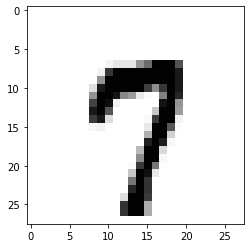

In [20]:
#테스트 데이터를 이용하여 모델 테스트 
#torch.no_grad() 사용시 gradient 계산 수행 X

with torch.no_grad():
    X_test = mnist_test.test_data.view(-1,28*28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()
